In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchmetrics
import torch.nn.init as init

    

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### pytorch

In [3]:
class LinuxDatasetObject(Dataset):
    def __init__(self, dataset, labels):
        self.dataset = torch.tensor(dataset).to(device)
        self.labels = torch.tensor(labels).to(device)

    def NumberOfFeatures(self):
        return self.dataset.shape[1]
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx], self.labels[idx]

In [4]:
def generate_train_test_samples( hdf_path: str, target_columns: list, columns_to_drop: list, device: str,
                                 test_size: float, feature_selection: int = 2):
        df = pd.read_hdf(hdf_path)
        y = df[target_columns].to_numpy()
        X = df.drop(columns= columns_to_drop).to_numpy()
                
        
        X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        X_train , X_val , y_train , y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        X_train_tensor = torch.from_numpy(X_train).type(torch.float).to(device)
        X_test_tensor = torch.from_numpy(X_test).type(torch.float).to(device)
        X_validation_tensor = torch.from_numpy(X_val).type(torch.float).to(device)
        y_test_tensor = torch.from_numpy(y_test).type(torch.float).to(device).squeeze()
        y_train_tensor = torch.from_numpy(y_train).type(torch.float).to(device).squeeze()
        y_validation_tensor = torch.from_numpy(y_val).type(torch.float).to(device).squeeze()

        return (X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,X_validation_tensor,y_validation_tensor)

### Generate data

In [4]:
#Full Path of the linux file
data_linux = ""

In [5]:
data = generate_train_test_samples(data_linux, ["perf"], ["perf", "active_options"], device, 0.2, 0)

In [6]:
train = LinuxDatasetObject(data[0],data[1])

/tmp/ipykernel_134284/2030069999.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dataset = torch.tensor(dataset).to(device)
/tmp/ipykernel_134284/2030069999.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels).to(device)


In [7]:
Xtrain, ytrain = (data[0],data[1])
Xtest, ytest = (data[2],data[3])
Xval, yval = (data[4],data[5])

In [8]:
def train_dataloader(train_data: LinuxDatasetObject, batch_size: int, shuffle: bool = True):
    return DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    
def test_dataloader(test_data: LinuxDatasetObject, batch_size: int, shuffle: bool = False):
    return DataLoader(test_data, batch_size=batch_size, shuffle=shuffle)

def validation_dataloader(val_data: LinuxDatasetObject, batch_size: int, shuffle: bool = False):
    return DataLoader(val_data, batch_size=batch_size, shuffle=shuffle)

In [9]:
import copy


class EarlyStopping:
    def __init__(self, pation: int = 15, min_delta: int = 0):
        self.pation = pation
        self.min_delta = min_delta
        self.best_model = None
        self.best_loss = None
        self.counter = 0

    def __call__(self, model: nn.Module, val_loss: float, name_of_the_model_save: str = "result"):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        elif val_loss <= self.best_loss:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.pation:
                model.load_state_dict(self.best_model)
                torch.save(self.best_model, f=name_of_the_model_save)
                return True
            
        return False

In [10]:
def plot_results(epoch, train_loss, validation_loss):
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    ax = sns.lineplot(y=np.array(train_loss), x=np.array(epoch), label="loss", palette="binary")
    ax.set(xlabel= 'epochs', ylabel= 'train_loss')
    plt.title("Train Loss")
    #----------------------------------------------------------------
    plt.subplot(1,3,2)
    ax = sns.lineplot(y=np.array(train_loss), x=np.array(epoch), label="test loss", palette="flare")
    ax.set(xlabel= 'epochs', ylabel= 'train_loss')
    ax = sns.lineplot(x=np.array(epoch), y=np.array(validation_loss), label="Loss Convergence", color="red")
    ax.set(xlabel= 'epochs', ylabel= 'validation_loss')
    plt.title("Train Vs Validation")
    #----------------------------------------------------------------
    plt.subplot(1,3,3)
    absolut_loss = np.subtract(validation_loss, train_loss)
    ax = sns.lineplot(x=np.array(epoch), y=absolut_loss, label="Loss Convergence", color="red")
    ax.set(xlabel= 'epochs', ylabel= 'Vloss - Tloss')
    plt.title("Loss Convergence")

In [11]:
class Model1(nn.Module):
    def __init__(self, features: int, classes: int):
        super().__init__()
        self.inputLayer = nn.Linear(features, int(features))
        self.activationLayer = nn.ELU()
        self.hiddenLayer1 = nn.Linear(int(features),int((features)))
        self.dropout = nn.Dropout(0.0)
        self.hiddenLayer2 = nn.Linear(int((features)),int((features)))
        self.outputLayer = nn.Linear(int((features)), classes)
        init.kaiming_normal_(self.hiddenLayer1.weight)
        init.kaiming_normal_(self.hiddenLayer2.weight)
        init.kaiming_normal_(self.inputLayer.weight)

    def forward(self,x):
        z = self.inputLayer(x)
        z = self.activationLayer(self.hiddenLayer1(z))
        z = self.dropout(z)
        z = self.activationLayer(self.hiddenLayer2(z))
        z = self.dropout(z)
        z = self.outputLayer(z)
        return z


model1 = Model1(train.NumberOfFeatures(), 1).to(device)
model1

Model1(
  (inputLayer): Linear(in_features=9467, out_features=9467, bias=True)
  (activationLayer): ELU(alpha=1.0)
  (hiddenLayer1): Linear(in_features=9467, out_features=9467, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (hiddenLayer2): Linear(in_features=9467, out_features=9467, bias=True)
  (outputLayer): Linear(in_features=9467, out_features=1, bias=True)
)

In [12]:
optimizer = torch.optim.AdamW(model1.parameters(), lr=0.001)
loss_fn = nn.SmoothL1Loss().to(device)
#loss_fn = torchmetrics.MeanSquaredError().to(device)
#loss_fn = torchmetrics.MeanAbsolutePercentageError().to(device)
#loss_fn = torchmetrics.MeanAbsoluteError().to(device)

In [13]:
train_loader = train_dataloader(train, 4096)

In [14]:
from time import time

In [15]:
epochs = 800
loss_cont = []
test_loss_cont = []
val_loss_cont = []
epoch_cont = []

es = EarlyStopping()

ini = time()
for epoch in range(epochs):
    for batch_data, batch_labels in train_loader:
        model1.train()
        y_pred = model1(batch_data).squeeze()

        loss = loss_fn(y_pred, batch_labels)
                
        optimizer.zero_grad()

        loss.backward()
                
        optimizer.step()

    with torch.inference_mode():
        y_pred = model1(Xtrain).squeeze()
        loss_train = loss_fn(y_pred, ytrain)
        test_pred = model1(Xtest).squeeze()
        loss_test = loss_fn(test_pred, ytest)
        val_pred = model1(Xval).squeeze()
        loss_val = loss_fn(val_pred, yval)

        loss_cont.append(torch.Tensor.cpu(loss).detach().numpy())
        val_loss_cont.append(torch.Tensor.cpu(loss_val).detach().numpy())
        test_loss_cont.append(torch.Tensor.cpu(loss_test).detach().numpy())
        epoch_cont.append(epoch)

        if es(model1, loss_val):
            print(f"Loss de treino final: {es.best_loss}")
            break
        
    print(f"epoch {epoch}, train_loss = {loss}, test_loss = {loss_test}, val_loss = {loss_val}")
now = time()    

print("tempo de treino: ", str(now - ini))

epoch 0, train_loss = 40355692.0, test_loss = 35453564.0, val_loss = 35409832.0
epoch 1, train_loss = 30614564.0, test_loss = 25497820.0, val_loss = 25525570.0
epoch 2, train_loss = 23962786.0, test_loss = 23651862.0, val_loss = 23703644.0
epoch 3, train_loss = 25912302.0, test_loss = 23232794.0, val_loss = 23286220.0
epoch 4, train_loss = 23591214.0, test_loss = 23074492.0, val_loss = 23130714.0
epoch 5, train_loss = 23871262.0, test_loss = 22933286.0, val_loss = 22975638.0
epoch 6, train_loss = 20818526.0, test_loss = 22820310.0, val_loss = 22851282.0
epoch 7, train_loss = 23388312.0, test_loss = 22675942.0, val_loss = 22704798.0
epoch 8, train_loss = 23032652.0, test_loss = 22533690.0, val_loss = 22555026.0
epoch 9, train_loss = 25144620.0, test_loss = 22371504.0, val_loss = 22386694.0
epoch 10, train_loss = 20957484.0, test_loss = 22176346.0, val_loss = 22190694.0
epoch 11, train_loss = 20026660.0, test_loss = 21936062.0, val_loss = 21956910.0
epoch 12, train_loss = 26037824.0, tes

epoch 102, train_loss = 5545334.0, test_loss = 9154782.0, val_loss = 9366917.0
epoch 103, train_loss = 6408578.0, test_loss = 8919183.0, val_loss = 9179102.0
epoch 104, train_loss = 6497557.5, test_loss = 9011371.0, val_loss = 9331378.0
epoch 105, train_loss = 8439331.0, test_loss = 8705036.0, val_loss = 9014419.0
epoch 106, train_loss = 8734799.0, test_loss = 8757913.0, val_loss = 9025409.0
epoch 107, train_loss = 6662625.5, test_loss = 8808949.0, val_loss = 9142003.0
epoch 108, train_loss = 7011196.5, test_loss = 8798375.0, val_loss = 9085687.0
epoch 109, train_loss = 6871274.0, test_loss = 8518956.0, val_loss = 8795122.0
epoch 110, train_loss = 6386375.5, test_loss = 8746702.0, val_loss = 9066803.0
epoch 111, train_loss = 5545784.5, test_loss = 8413847.0, val_loss = 8699551.0
epoch 112, train_loss = 9056424.0, test_loss = 8632853.0, val_loss = 8863219.0
epoch 113, train_loss = 10115199.0, test_loss = 8647456.0, val_loss = 8945580.0
epoch 114, train_loss = 7034884.0, test_loss = 8890

epoch 206, train_loss = 2854062.0, test_loss = 7699839.5, val_loss = 7839406.0
epoch 207, train_loss = 2726483.25, test_loss = 7627221.0, val_loss = 7780015.5
epoch 208, train_loss = 2350236.25, test_loss = 7540865.0, val_loss = 7704634.5
epoch 209, train_loss = 2892359.5, test_loss = 7591227.0, val_loss = 7763979.0
Loss de treino final: 7674814.5
tempo de treino:  1715.2133915424347


In [19]:
loss_fn = torchmetrics.MeanAbsolutePercentageError().to(device)
test_pred = model1(Xtest).squeeze()
loss_test = loss_fn(test_pred, ytest)
loss_test

tensor(0.0855, device='cuda:0', grad_fn=<SqueezeBackward0>)

/tmp/ipykernel_134284/3420242909.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(y=np.array(train_loss), x=np.array(epoch), label="loss", palette="binary")
/tmp/ipykernel_134284/3420242909.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(y=np.array(train_loss), x=np.array(epoch), label="test loss", palette="flare")


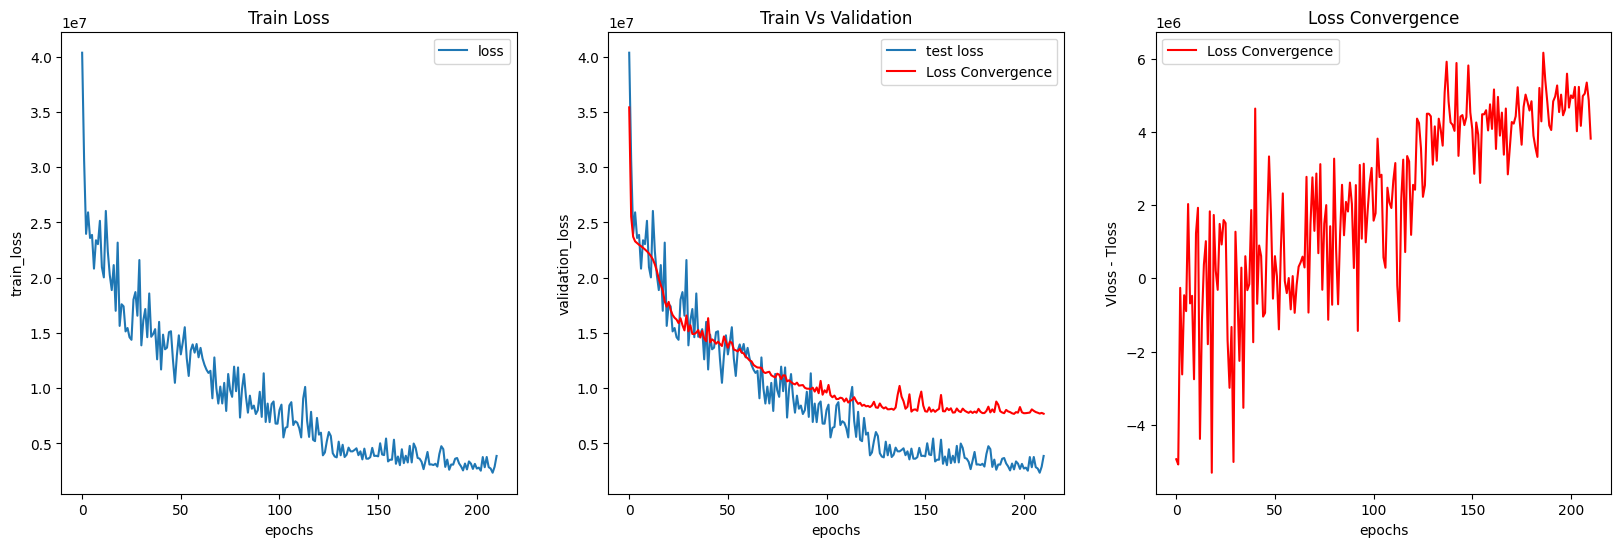

In [20]:
plot_results(epoch_cont, loss_cont, val_loss_cont)

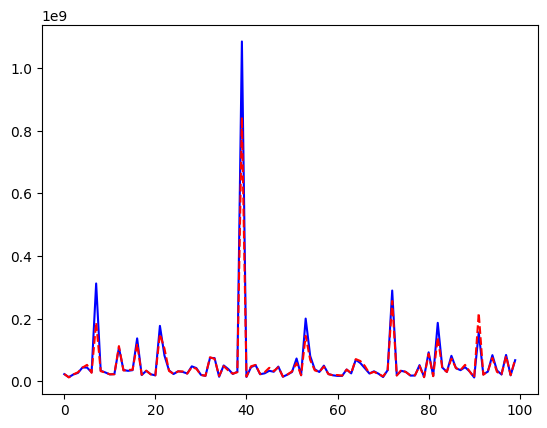

In [21]:

pred = model1(Xtest).cpu().detach().numpy()

plt.plot(ytest.cpu().detach().numpy()[:100], color = 'b')
plt.plot(pred[:100], color = 'r', linestyle = 'dashed')
plt.show()